In [130]:
from typing import List, Tuple
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import openfermion as of
import cirq
import qiskit
from qiskit.qasm2 import dumps
from cirq.contrib.qasm_import import circuit_from_qasm
from convert import cirq_pauli_sum_to_qiskit_pauli_op

In [131]:
# See Kirby paper
def upper_bound(H_norm, overlap, d, delta, delta_prime, Delta_prime, chi, zeta):
    term0 = delta_prime if delta_prime > Delta_prime else 0
    term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi
    term2 = (6*H_norm/overlap)*zeta
    term3 = (6*H_norm/overlap)*8*(1+0.5*np.pi*delta/H_norm)**(-2*d)
    out = term0+term1+term2+term3
    return out

In [132]:
def minimized_bound(H_norm, overlap_prime, d, Delta, Delta_prime, chi, zeta):
    def upper_bound_fn(x):
            return upper_bound(H_norm, overlap_prime, d, x[0], x[1], Delta_prime, chi, zeta)
        
    if Delta_prime > 0:
        x0 = (Delta_prime/2, Delta_prime)
    else:
        x0 = (Delta/2,Delta)
    
    
    # Minimize over values of delta and delta_prime:
    min_bound = sp.optimize.minimize(
        upper_bound_fn,
        method='COBYLA',
        x0=x0,
        constraints=(
            {'type': 'ineq', 'fun': lambda x:  x[1]-x[0]-chi/overlap_prime},
            {'type': 'ineq', 'fun': lambda x:  x[0]},
            {'type': 'ineq', 'fun': lambda x:  x[1]},
            {'type': 'ineq', 'fun': lambda x:  (Delta_prime-0.01 if Delta_prime>0.01 else Delta) - x[1]}
        )
    )
    
    if min_bound.fun < upper_bound_fn(x0):
        bound = min_bound.fun
    else:
        print('Minimization failed bound', min_bound.fun, 'replaced with default (initial) point')
        bound = upper_bound_fn(x0)
    return bound

In [133]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray],
    matrix: np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(i, j)
            hij = vectors[i].conj().T @ matrix @ vectors[j]
            h[i, j] = hij

            if i != j:
                h[j, i] = np.conjugate(hij)

            sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s

In [134]:
# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float,
) -> float:
    if np.isclose(threshold, 0, atol=1e-10):
        h_reg = h
        s_reg = s
    else:
        s_vals, s_vecs = sp.linalg.eigh(s)
        s_vecs = s_vecs.T
        good_vecs = np.array(
            [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
        )
        h_reg = good_vecs.conj() @ h @ good_vecs.T
        s_reg = good_vecs.conj() @ s @ good_vecs.T
        return sp.linalg.eigh(h_reg, s_reg)[0][0]

In [135]:
l = 2
t = 1.0
u = 4.0
hamiltonian_fermi = of.hamiltonians.fermi_hubbard(
    l, l, t, u, spinless=True, periodic=False
)
hamiltonian = of.transforms.jordan_wigner(hamiltonian_fermi)
nqubits = of.utils.count_qubits(hamiltonian)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(hamiltonian)
ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
matrix = ham_cirq.matrix()
ham_norm = np.linalg.norm(matrix)

evals_exact, evecs_exact = np.linalg.eigh(matrix)
ground_state = evecs_exact.T[0]
energy_exact = min(evals_exact)
print("Exact energy:", energy_exact)

sorted_evals_exact = sorted(evals_exact)
excited_energy = sorted_evals_exact[1]
print("Excited state energy =", excited_energy)
big_delta = excited_energy - energy_exact
print("Delta =", big_delta)

bvec = ground_state + np.random.randn(ground_state.shape[0]) / 5.0
bvec /= np.linalg.norm(bvec)

overlap = np.abs(bvec.conj().T @ ground_state) ** 2
print("Overlap =", overlap)

Exact energy: -2.0
Excited state energy = -0.8284271247461893
Delta = 1.1715728752538106
Overlap = 0.5257408527899662


## Get subspace matrices with U.

In [136]:
subspace_dimension = 10
threshold = 1e-4

In [137]:
dt = np.pi / (evals_exact[-1] - evals_exact[0])

vectors_u = []
for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
    print(k)
    Uk = sp.linalg.expm(-1j * matrix * k * dt)
    vectors_u.append(Uk @ bvec)

-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


In [138]:
h_u, s_u = fill_h_and_s_matrices(vectors_u, matrix)

In [139]:
krylov_u_evals = []
for d in range(1, len(h_u)):
    krylov_energy = solve_regularized_gen_eig(h_u[:d, :d], s_u[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_u_evals.append(krylov_energy)

1.1954706784418205
-0.7283263306893581
-1.5733549085496608
-1.8122356930066645
-1.9570303859906273
-1.9918165190617054
-1.9877533710856765
-1.9971974623171471
-1.9958474059663998
-1.998766551360097
-1.9984224089812765
-1.997996485674646
-1.9993566769862827
-1.9991731630414569
-1.998857576009409
-1.9999999999999962
-2.0
-2.0000000000000004
-2.000000000000001
-1.9999999999999984
-1.9999999999999991
-1.9999999999999978
-1.9999999999999998
-1.9999999999999991
-2.0000000000000013
-2.0000000000000018
-1.9999999999999991
-2.0
-1.9999999999999996
-2.0000000000000013
-2.0000000000000004
-2.0
-1.9999999999999996
-2.0
-2.000000000000001
-1.9999999999999993
-2.0000000000000018
-1.9999999999999978
-2.000000000000001
-1.9999999999999984


/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_64581/215692311.py:17: RuntimeWarning: divide by zero encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_64581/215692311.py:17: RuntimeWarning: overflow encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_64581/215692311.py:17: RuntimeWarning: invalid value encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_64581/215692311.py:18: RuntimeWarning: divide by zero encountered in matmul
  s_reg = good_vecs.conj() @ s @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_64581/215692311.py:18: RuntimeWarning: overflow encountered in matmul
  s_reg = good_vecs.conj() @ s @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_64581/215692311.py:18: RuntimeWarning: invalid value e

## Get subspace matrices with Trotter.

In [140]:
ntrotter_values = [1, 2, 4, 8, 16, 32]
ngates_twoq = []
ngates_oneq = []
depths = []
all_krylov_u_trotter_evals = []
all_trotter_h = []
all_trotter_s = []

for ntrotter in ntrotter_values:
    print("On ntrotter =", ntrotter)
    trotter_operation = qiskit.circuit.library.PauliEvolutionGate(
        ham_qiskit,
        time=dt,
        synthesis=qiskit.synthesis.LieTrotter(reps=ntrotter)
    )

    # trotter_circuit = qiskit.QuantumCircuit.from_instructions(
    #     [[trotter_operation]],
    #     qubits=qiskit.QuantumRegister(trotter_operation.num_qubits),
    # )
    trotter_circuit = qiskit.QuantumCircuit(nqubits)
    trotter_circuit.append(trotter_operation, trotter_circuit.qubits)
    trotter_circuit = qiskit.transpile(
        trotter_circuit, basis_gates=["u3", "cx"]
    )  # TODO: Compile to a target backend, e.g. IBM Fez.
    opcounts = trotter_circuit.count_ops()
    ngates_twoq.append(opcounts.get("cx"))
    ngates_oneq.append(opcounts.get("u3"))
    depths.append(trotter_circuit.depth())

    qasm = dumps(trotter_circuit)
    trotter_circuit_cirq = circuit_from_qasm(qasm.replace("qregless", "q"))

    qubits = sorted(trotter_circuit_cirq.all_qubits())
    Utrotter = cirq.unitary(trotter_circuit_cirq)

    vectors_u_trotter = []
    for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
        # print(k)
        Uk = np.linalg.matrix_power(Utrotter, k)
        vectors_u_trotter.append(Uk @ bvec)
    
    h, s = fill_h_and_s_matrices(vectors_u_trotter, matrix)
    krylov_u_trotter_evals = []
    for d in range(1, len(h)):
        krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
        krylov_u_trotter_evals.append(krylov_energy)
    
    all_krylov_u_trotter_evals.append(krylov_u_trotter_evals)
    all_trotter_h.append(h)
    all_trotter_s.append(s)

On ntrotter = 1
On ntrotter = 2
On ntrotter = 4
On ntrotter = 8
On ntrotter =

/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: divide by zero encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: overflow encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: invalid value encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: divide by zero encountered in matmul
  result = z if result is None else fmatmul(result, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)
/Users/benjamindalfavero/.venv/compare

 16
On ntrotter = 32


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: divide by zero encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: overflow encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: invalid value encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: divide by zero encountered in matmul
  result = z if result is None else fmatmul(result, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)
/Users/benjamindalfavero/.venv/compare

In [173]:
all_h_distances = []
all_s_distances = []
all_chis = []
all_overlap_primes = []
all_delta_primes = []
all_zetas = []
for h, s in zip(all_trotter_h, all_trotter_s):
    h_dist = sp.linalg.norm(h_u - h, ord=2)
    all_h_distances.append(h_dist)
    s_dist = sp.linalg.norm(s_u - s, ord=2)
    all_s_distances.append(s_dist)
    chi = h_dist + ham_norm * s_dist
    all_chis.append(chi)
    overlap_prime = overlap - 2 * threshold - 2 * s_dist
    all_overlap_primes.append(overlap_prime)
    delta_prime = big_delta - chi / overlap_prime
    all_delta_primes.append(delta_prime)
    zeta = 2 * subspace_dimension * (threshold + s_dist)
    all_zetas.append(zeta)

In [174]:
all_bounds = []
for i in range(len(all_h_distances)):
    overlap_prime = all_overlap_primes[i]
    delta_prime = all_delta_primes[i]
    chi = all_chis[i]
    zeta = all_zetas[i]
    bound = minimized_bound(ham_norm, overlap_prime, subspace_dimension, big_delta, delta_prime, chi, zeta)
    all_bounds.append(bound)
    print(bound)

-27709083.296282902
Minimization failed bound 17101244.116018303 replaced with default (initial) point
-1783.7517450127375
-11050299.599503748
Minimization failed bound 23296425.38933144 replaced with default (initial) point
-1783.7517195328828
-11106683.99422216
Minimization failed bound 17889492.16159696 replaced with default (initial) point
-1783.7517179730753


In [175]:
print(len(all_bounds))

6


In [176]:
# Convert all Trotterized eigenvalues into a dataframe.
dfs = []
for evals, ntrotter in zip(all_krylov_u_trotter_evals, ntrotter_values):
    errs = np.abs(evals - energy_exact)
    df = pd.DataFrame({"d": range(len(evals)), "energy": evals, "error": errs})
    df["ntrotter"] = ntrotter
    dfs.append(df)
big_df = pd.concat(dfs)
print(big_df.head())

   d    energy     error  ntrotter
0  0  1.161129  3.161129         1
1  1 -0.760787  1.239213         1
2  2 -1.578554  0.421446         1
3  3 -1.814658  0.185342         1
4  4 -1.945668  0.054332         1


In [177]:
d_vals = np.unique(big_df["d"])
selected_d_vals = [5, 10, 15, 20, 25, 30]
assert set(selected_d_vals).issubset(set(d_vals))

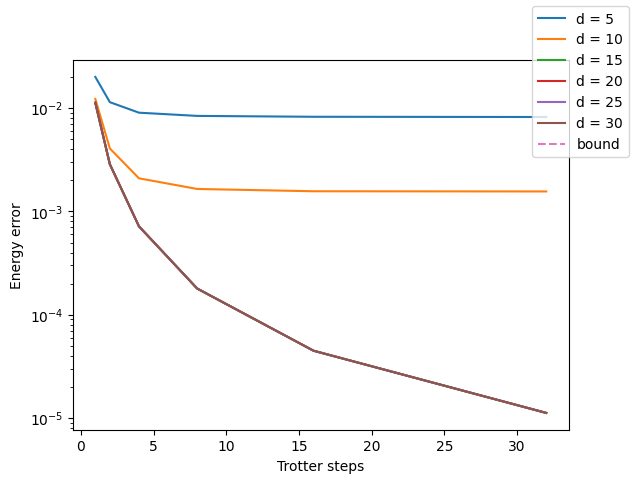

In [178]:
fig, ax = plt.subplots()

for d in selected_d_vals:
    df_d = big_df[big_df["d"] == d]
    ax.plot(df_d["ntrotter"], df_d["error"], label=f"d = {d}")

ax.plot(ntrotter_values, all_bounds, "--", label="bound")
ax.set_yscale("log")
ax.set_xlabel("Trotter steps")
ax.set_ylabel("Energy error")
fig.legend()

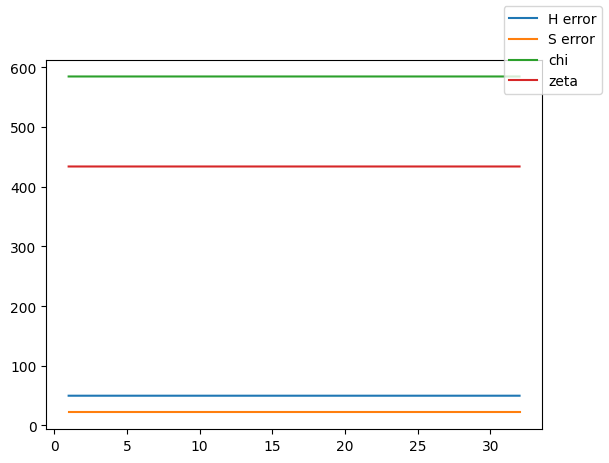

In [179]:
fig2, ax2 = plt.subplots()
ax2.plot(ntrotter_values, all_h_distances, label="H error")
ax2.plot(ntrotter_values, all_s_distances, label="S error")
ax2.plot(ntrotter_values, all_chis, label="chi")
ax2.plot(ntrotter_values, all_zetas, label="zeta")
fig2.legend()

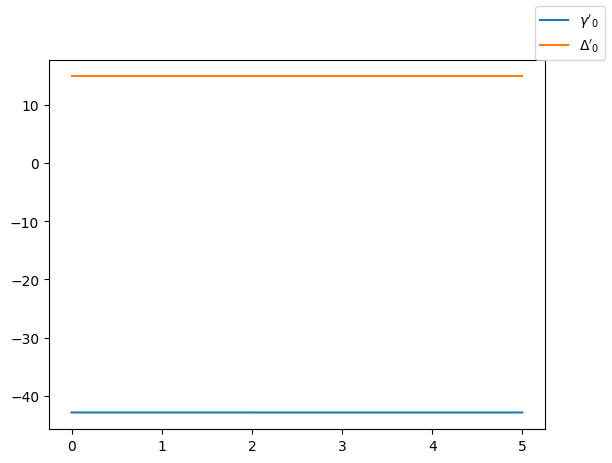

In [180]:
fig3, ax3 = plt.subplots()
ax3.plot(all_overlap_primes, label=r"$\gamma'_0$")
ax3.plot(all_delta_primes, label=r"$\Delta'_0$")
fig3.legend()